**Personality Profiler AI**

This project explores how machine learning models can classify synthetic human personality types — **Introvert**, **Extrovert**, and **Ambivert** — using behavioral traits. We evaluate multiple models, apply explainable AI (SHAP), test robustness against noise, and visualize results with PCA.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from copy import deepcopy
import shap
import warnings
warnings.filterwarnings("ignore")

**Step 1: Load & Inspect Dataset**

Load Data

In [2]:
data = pd.read_csv("/kaggle/input/introvert-extrovert-and-ambivert-classification/personality_synthetic_dataset.csv")

Display basic information about the DataFrame

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   personality_type          20000 non-null  object 
 1   social_energy             20000 non-null  float64
 2   alone_time_preference     20000 non-null  float64
 3   talkativeness             20000 non-null  float64
 4   deep_reflection           20000 non-null  float64
 5   group_comfort             20000 non-null  float64
 6   party_liking              20000 non-null  float64
 7   listening_skill           20000 non-null  float64
 8   empathy                   20000 non-null  float64
 9   creativity                20000 non-null  float64
 10  organization              20000 non-null  float64
 11  leadership                20000 non-null  float64
 12  risk_taking               20000 non-null  float64
 13  public_speaking_comfort   20000 non-null  float64
 14  curios

Print statistical summary of numerical columns

In [4]:
print(data.describe())


       social_energy  alone_time_preference  talkativeness  deep_reflection  \
count   20000.000000           20000.000000   20000.000000     20000.000000   
mean        5.509190               5.454690       5.525955         5.958689   
std         2.468526               2.493731       2.488006         2.162427   
min         0.000000               0.000000       0.000000         0.000000   
25%         3.590989               3.509578       3.595866         4.382619   
50%         5.540706               5.464038       5.574786         5.972345   
75%         7.424123               7.416314       7.472371         7.598495   
max        10.000000              10.000000      10.000000        10.000000   

       group_comfort  party_liking  listening_skill       empathy  \
count   20000.000000  20000.000000     20000.000000  20000.000000   
mean        6.014381      5.040063         6.964450      6.483220   
std         2.178551      2.810563         1.647944      1.534911   
min         

Count and display the number of missing values in each column

In [5]:
print("\nMissing values per column:\n", data.isnull().sum())


Missing values per column:
 personality_type            0
social_energy               0
alone_time_preference       0
talkativeness               0
deep_reflection             0
group_comfort               0
party_liking                0
listening_skill             0
empathy                     0
creativity                  0
organization                0
leadership                  0
risk_taking                 0
public_speaking_comfort     0
curiosity                   0
routine_preference          0
excitement_seeking          0
friendliness                0
emotional_stability         0
planning                    0
spontaneity                 0
adventurousness             0
reading_habit               0
sports_interest             0
online_social_usage         0
travel_desire               0
gadget_usage                0
work_style_collaborative    0
decision_speed              0
stress_handling             0
dtype: int64


 Fill missing numeric values with their respective column means

In [6]:
data.fillna(data.mean(numeric_only=True), inplace=True)


**Step 2: Exploratory Data Analysis**

Class Distribution


Class Distribution:
personality_type
Extrovert    6857
Ambivert     6573
Introvert    6570
Name: count, dtype: int64


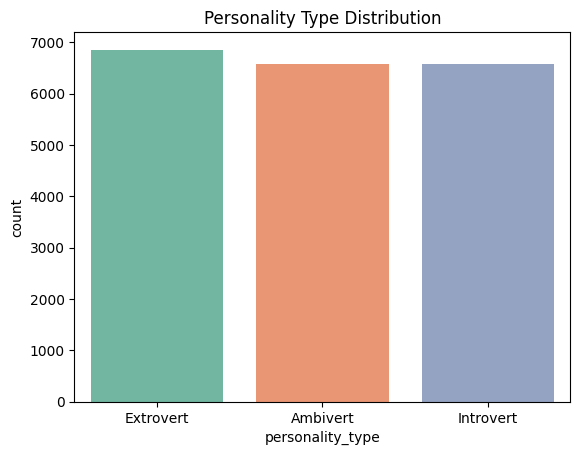

In [7]:
print("\nClass Distribution:")
print(data['personality_type'].value_counts())
sns.countplot(data=data, x='personality_type', palette='Set2')
plt.title("Personality Type Distribution")
plt.show()


Histograms for feature distributions

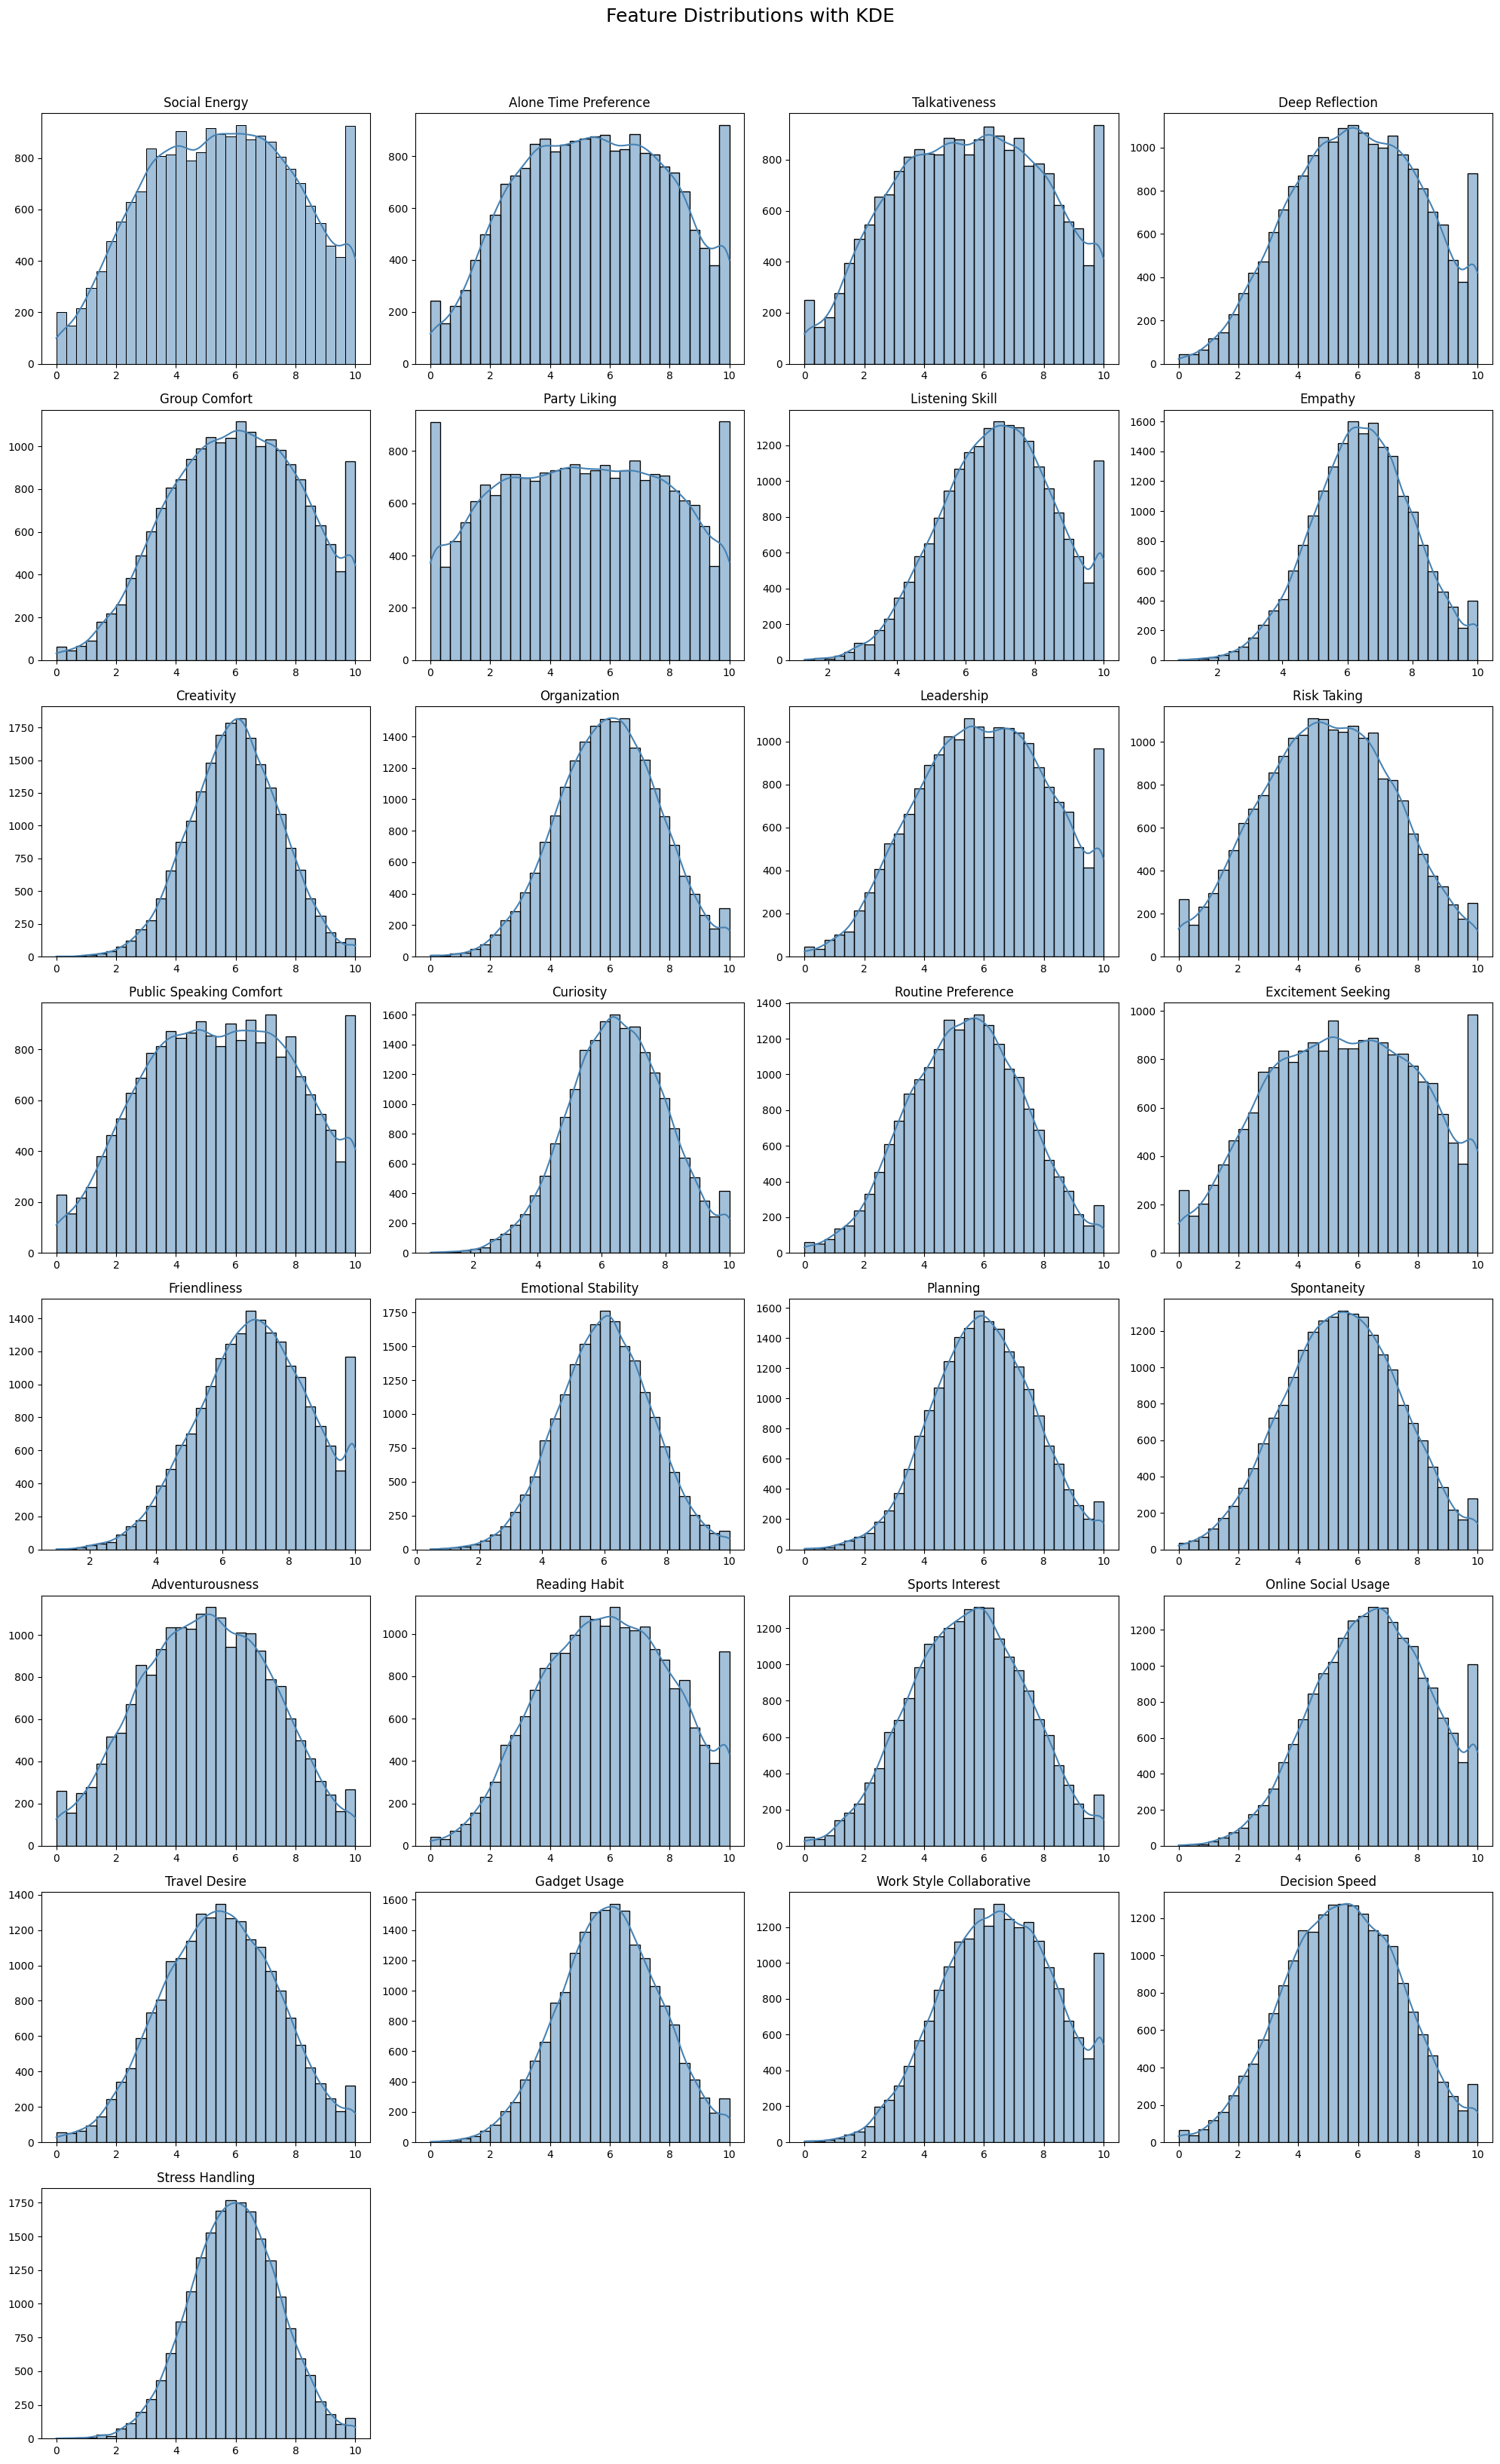

In [8]:
numeric_features = data.select_dtypes(include='number').columns.drop('label', errors='ignore')
num_features = len(numeric_features)
cols = 4
rows = math.ceil(num_features / cols)

plt.figure(figsize=(cols*5, rows*4))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[col], kde=True, bins=30, color='steelblue')
    plt.title(col.replace('_', ' ').title())
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()

plt.suptitle("Feature Distributions with KDE", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

Heatmap for feature correlation

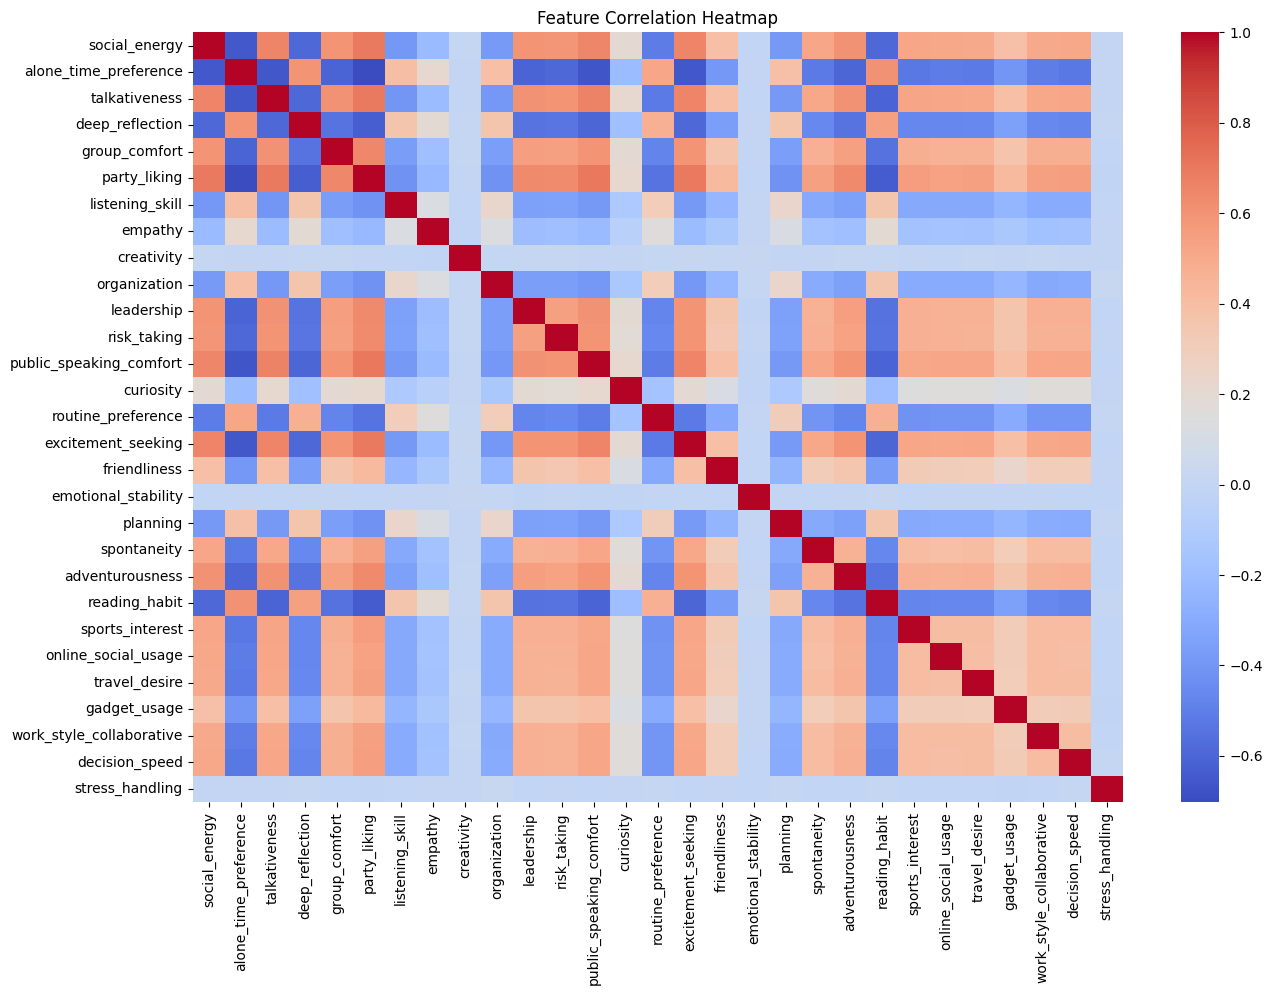

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(data.drop('personality_type', axis=1).corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

**Step 3: Preprocessing**

Encode the categorical target variable 

In [10]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['personality_type'])


Separate features (X) from the target label (y)

In [11]:
X = data.drop(['personality_type', 'label'], axis=1)
y = data['label']

Standardize the feature values to have mean = 0 and std = 1

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the dataset into training and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


**Step 4: Model Training & Evaluation**

Define a dictionary of machine learning models to train and evaluate

In [14]:
original_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

Prepare a dictionary to store accuracy results

In [15]:
results = {}

Duplicate the models to preserve the original definitions

In [16]:
models = deepcopy(original_models)

Train and evaluate each model, then display classification report and confusion matrix



Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Ambivert       1.00      1.00      1.00      1315
   Extrovert       1.00      1.00      1.00      1371
   Introvert       1.00      1.00      1.00      1314

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



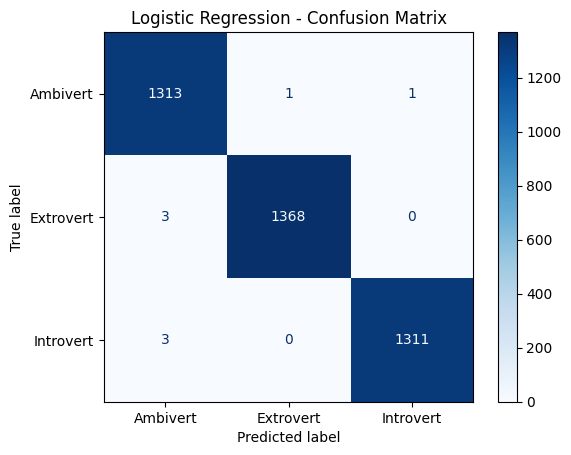


Random Forest Classification Report:
              precision    recall  f1-score   support

    Ambivert       0.99      1.00      0.99      1315
   Extrovert       1.00      0.99      1.00      1371
   Introvert       1.00      1.00      1.00      1314

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



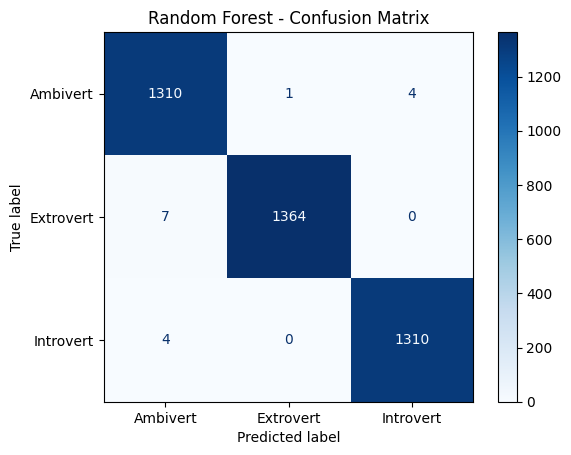


Decision Tree Classification Report:
              precision    recall  f1-score   support

    Ambivert       0.89      0.91      0.90      1315
   Extrovert       0.96      0.95      0.95      1371
   Introvert       0.95      0.94      0.95      1314

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000



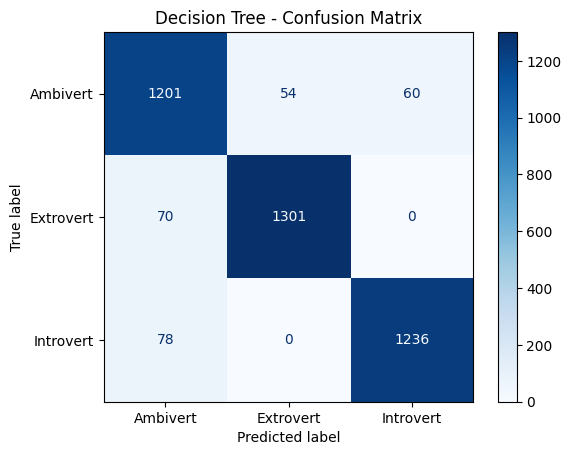


SVM Classification Report:
              precision    recall  f1-score   support

    Ambivert       1.00      1.00      1.00      1315
   Extrovert       1.00      1.00      1.00      1371
   Introvert       1.00      1.00      1.00      1314

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



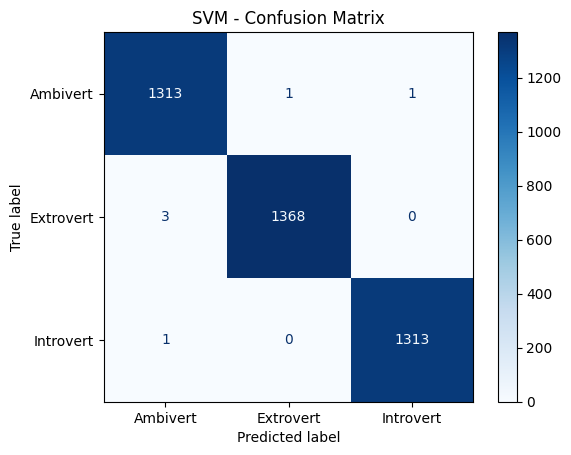


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Ambivert       1.00      1.00      1.00      1315
   Extrovert       1.00      1.00      1.00      1371
   Introvert       1.00      1.00      1.00      1314

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



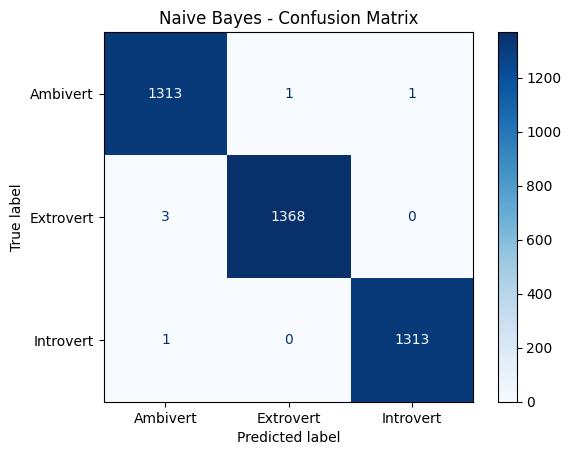


XGBoost Classification Report:
              precision    recall  f1-score   support

    Ambivert       0.99      1.00      0.99      1315
   Extrovert       1.00      0.99      1.00      1371
   Introvert       1.00      0.99      1.00      1314

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



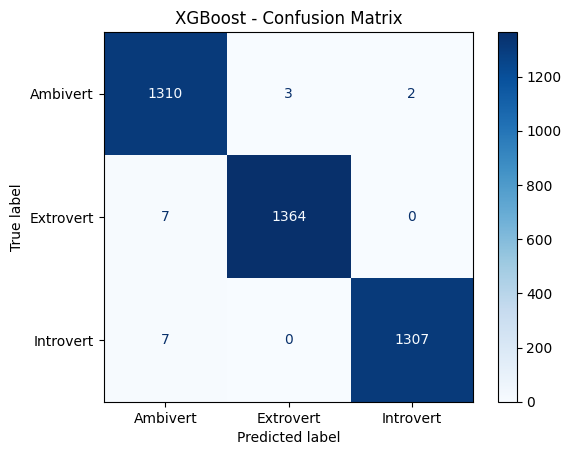

In [17]:
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    report = classification_report(y_test, preds, target_names=label_encoder.classes_, output_dict=True)
    results[name] = report['accuracy']
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=label_encoder.classes_, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

**Step 5: Metrics Comparison**

Initialize dictionary to store evaluation metrics

In [18]:
scores = {}

Print accuracy of all models, sorted from highest to lowest

In [19]:
print("\nModel Accuracy Comparison:")
for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {acc:.4f}")


Model Accuracy Comparison:
SVM: 0.9985
Naive Bayes: 0.9985
Logistic Regression: 0.9980
Random Forest: 0.9960
XGBoost: 0.9952
Decision Tree: 0.9345


Calculate F1, Precision, Recall, and ROC AUC scores for each model

In [20]:
print("\nF1, Precision, Recall, and ROC-AUC Scores:")
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    scores[name] = {'F1': f1, 'Precision': precision, 'Recall': recall}
    
    print(f"{name}:\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    if y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
            print(f"ROC AUC (OvR): {roc_auc:.4f}")
        except:
            print("ROC AUC: Not computable")


F1, Precision, Recall, and ROC-AUC Scores:
Logistic Regression:
F1: 0.9980, Precision: 0.9980, Recall: 0.9980
ROC AUC (OvR): 1.0000
Random Forest:
F1: 0.9960, Precision: 0.9960, Recall: 0.9960
ROC AUC (OvR): 0.9999
Decision Tree:
F1: 0.9344, Precision: 0.9347, Recall: 0.9343
ROC AUC (OvR): 0.9508
SVM:
F1: 0.9985, Precision: 0.9985, Recall: 0.9985
ROC AUC (OvR): 1.0000
Naive Bayes:
F1: 0.9985, Precision: 0.9985, Recall: 0.9985
ROC AUC (OvR): 1.0000
XGBoost:
F1: 0.9952, Precision: 0.9952, Recall: 0.9953
ROC AUC (OvR): 0.9999


Prepare data for visualization

In [21]:
metrics_df = pd.DataFrame(scores).T.reset_index().rename(columns={'index': 'Model'})
metrics_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


Create barplot for visual comparison of metrics

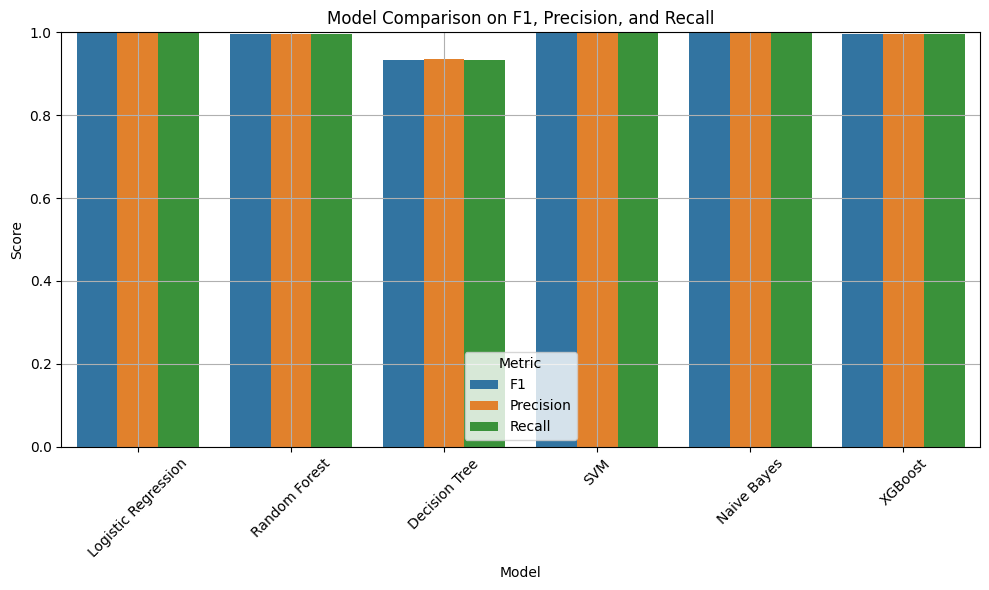

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison on F1, Precision, and Recall")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 6: Noise Injection and Robustness Testing**

Set random seed for reproducibility

In [23]:
np.random.seed(42)

Create a noisy copy of the original dataset

In [24]:
noisy_df = data.copy()

Identify all numeric feature columns

In [25]:
feature_cols = noisy_df.drop(['personality_type'], axis=1).select_dtypes(include='number').columns

Add Gaussian noise to each numeric feature (mean=0, std=0.2)

In [26]:
for col in feature_cols:
    noise = np.random.normal(0, 0.2, size=noisy_df.shape[0])
    noisy_df[col] += noise


Encode labels again for the noisy dataset

In [27]:
noisy_df['label'] = label_encoder.fit_transform(noisy_df['personality_type'])

Split features and target from noisy dataset

In [28]:
X_noisy = noisy_df.drop(['personality_type', 'label'], axis=1)
y_noisy = noisy_df['label']


Scale the noisy features

In [29]:
X_noisy_scaled = scaler.fit_transform(X_noisy)

Split the noisy dataset into training and test sets

In [30]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(
    X_noisy_scaled, y_noisy, test_size=0.2, stratify=y_noisy, random_state=42)


Evaluate all models on the noisy dataset


Model robustness with noisy data:
Logistic Regression Accuracy with noise: 0.9978


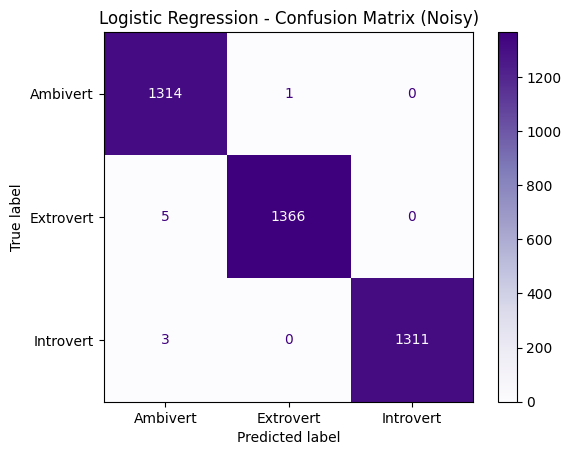

Random Forest Accuracy with noise: 0.9950


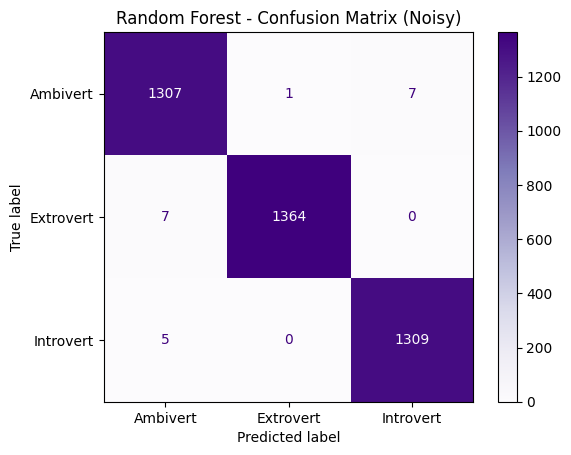

Decision Tree Accuracy with noise: 0.9395


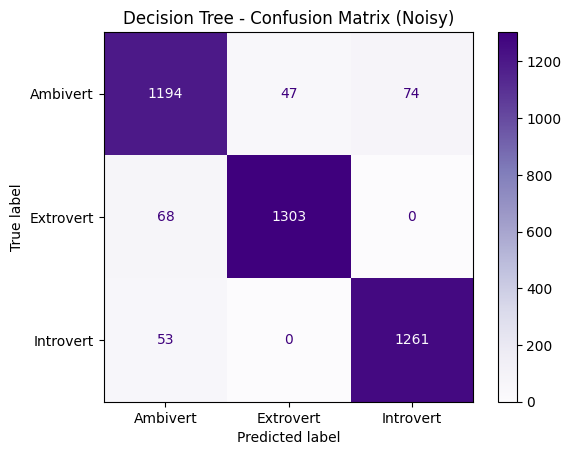

SVM Accuracy with noise: 0.9985


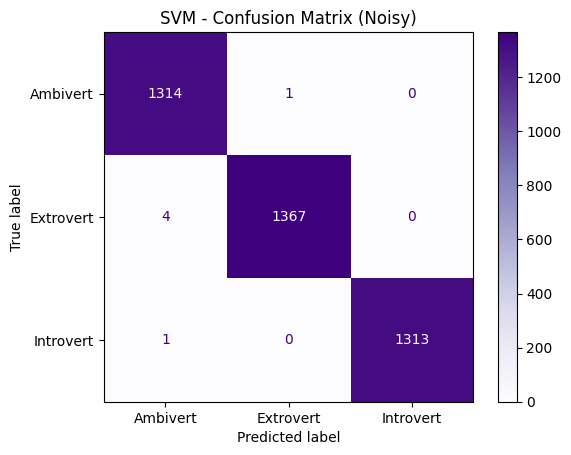

Naive Bayes Accuracy with noise: 0.9982


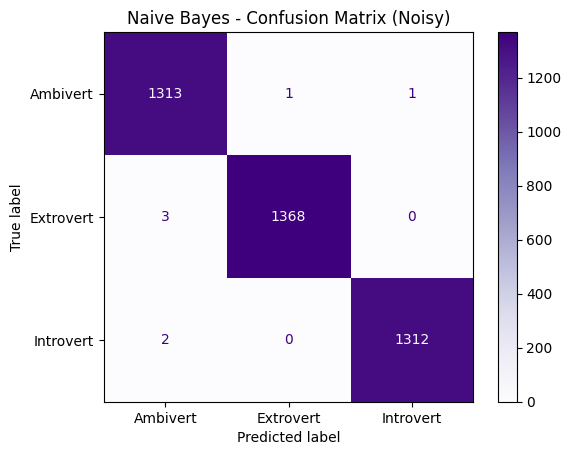

XGBoost Accuracy with noise: 0.9958


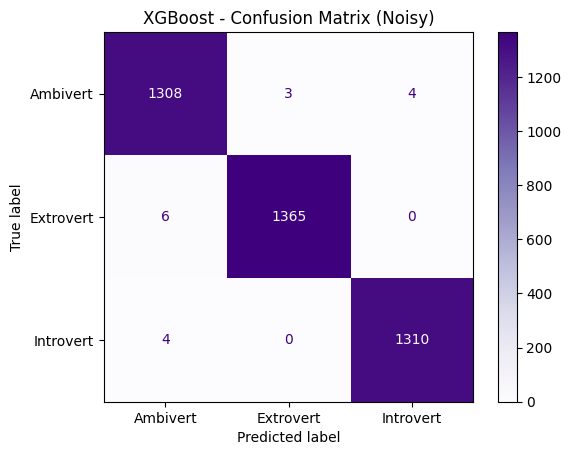

In [31]:
print("\nModel robustness with noisy data:")
noisy_results = {}
models = deepcopy(original_models)

for name, model in models.items():
    model.fit(X_train_noisy, y_train_noisy)
    preds_noisy = model.predict(X_test_noisy)
    acc_noisy = model.score(X_test_noisy, y_test_noisy)
    noisy_results[name] = acc_noisy
    print(f"{name} Accuracy with noise: {acc_noisy:.4f}")
    
    ConfusionMatrixDisplay.from_predictions(
        y_test_noisy, preds_noisy, display_labels=label_encoder.classes_, cmap="Purples")
    plt.title(f"{name} - Confusion Matrix (Noisy)")
    plt.show()

Visualize model performance under noise

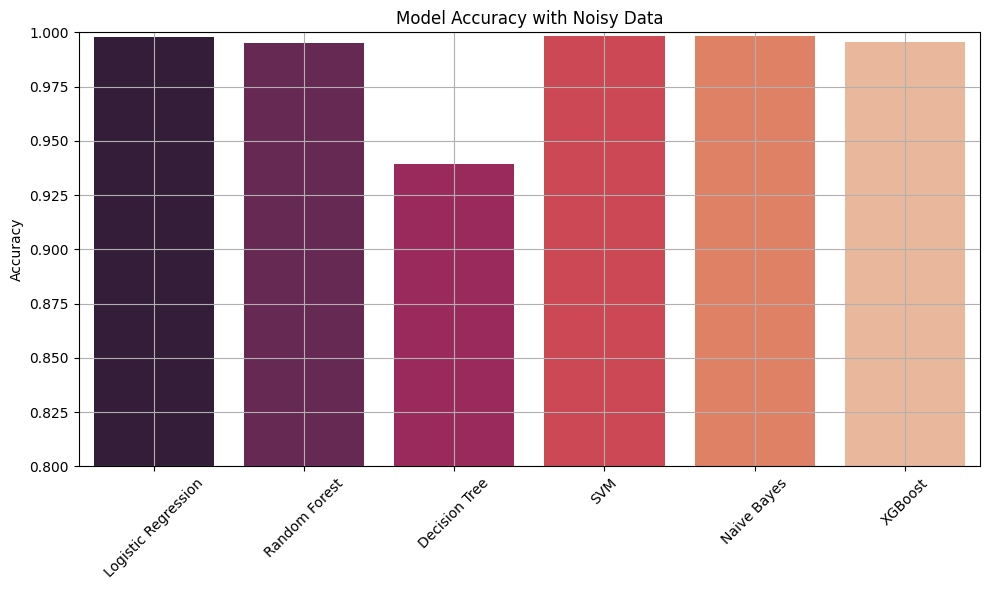

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x=list(noisy_results.keys()), y=list(noisy_results.values()), palette="rocket")
plt.title("Model Accuracy with Noisy Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 7: Clean vs Noisy Comparison**

Create a DataFrame comparing model accuracy on clean vs noisy data


In [33]:
comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Clean Data": [results[m] for m in results],
    "Noisy Data": [noisy_results[m] for m in noisy_results]
})

Reshape the DataFrame for seaborn barplot (long format)

In [34]:
comparison_df = comparison_df.melt(id_vars="Model", var_name="Data Type", value_name="Accuracy")


Plot the comparison

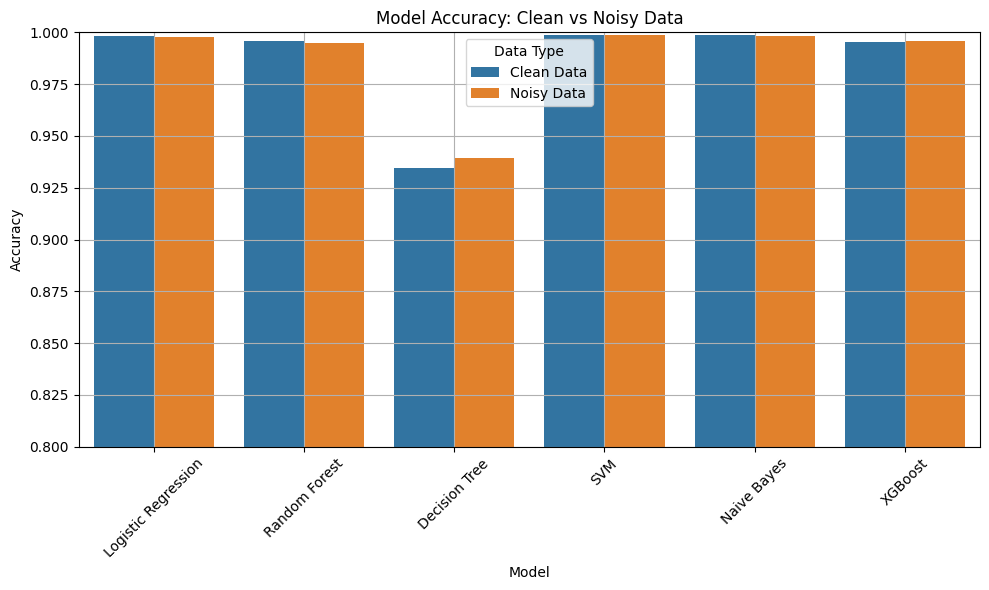

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(data=comparison_df, x="Model", y="Accuracy", hue="Data Type")
plt.title("Model Accuracy: Clean vs Noisy Data")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Step 8: SHAP Explanation (XGBoost Only)**

Display SHAP summary plot to interpret XGBoost model with noisy data

In [36]:
print("\nSHAP Summary Plot for XGBoost (with noisy data)")


SHAP Summary Plot for XGBoost (with noisy data)


Train a new XGBoost model on the noisy training data

In [37]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_noisy, y_train_noisy)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Create a SHAP explainer for the trained model

In [38]:
explainer = shap.TreeExplainer(xgb_model)

Compute SHAP values for the test set

In [39]:
shap_values = explainer.shap_values(X_test_noisy)

Generate SHAP summary plot showing global feature importance

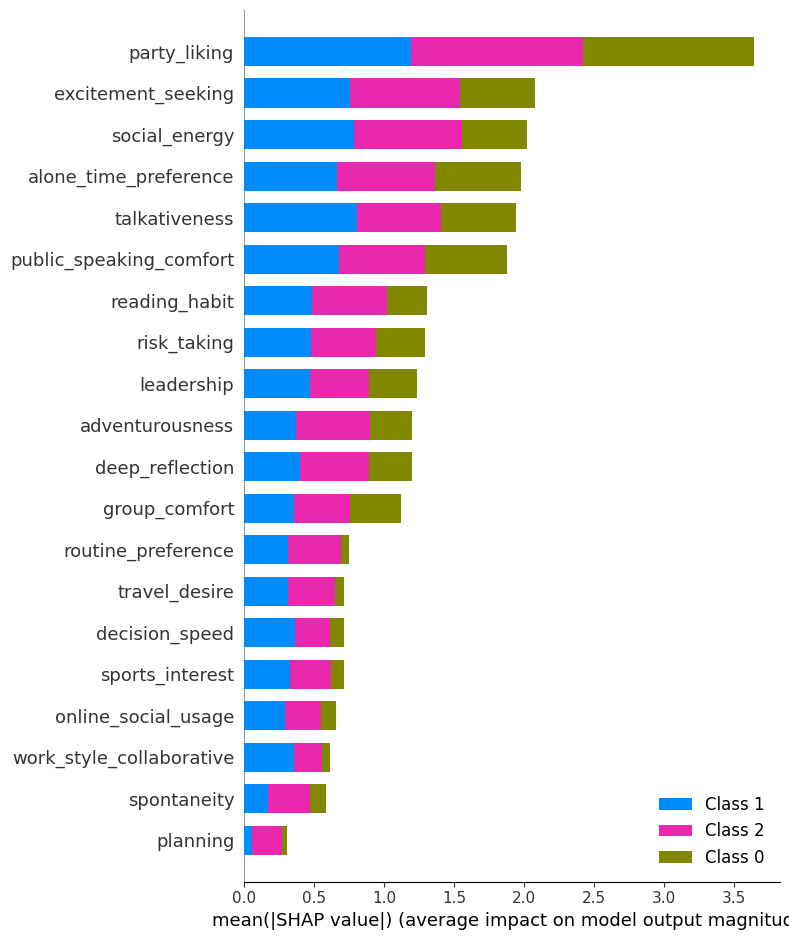

In [40]:
shap.summary_plot(shap_values, X_test_noisy, feature_names=X.columns.tolist())

**Step 9: PCA Visualization**


Print message for PCA visualization

In [41]:
print("\nPCA Visualization with Noisy Data")


PCA Visualization with Noisy Data


Apply PCA to reduce features to 2 principal components

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_noisy_scaled)

Create a DataFrame to store PCA results and labels

In [43]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Personality Type'] = label_encoder.inverse_transform(y_noisy)

Plot the PCA results with points colored by personality type

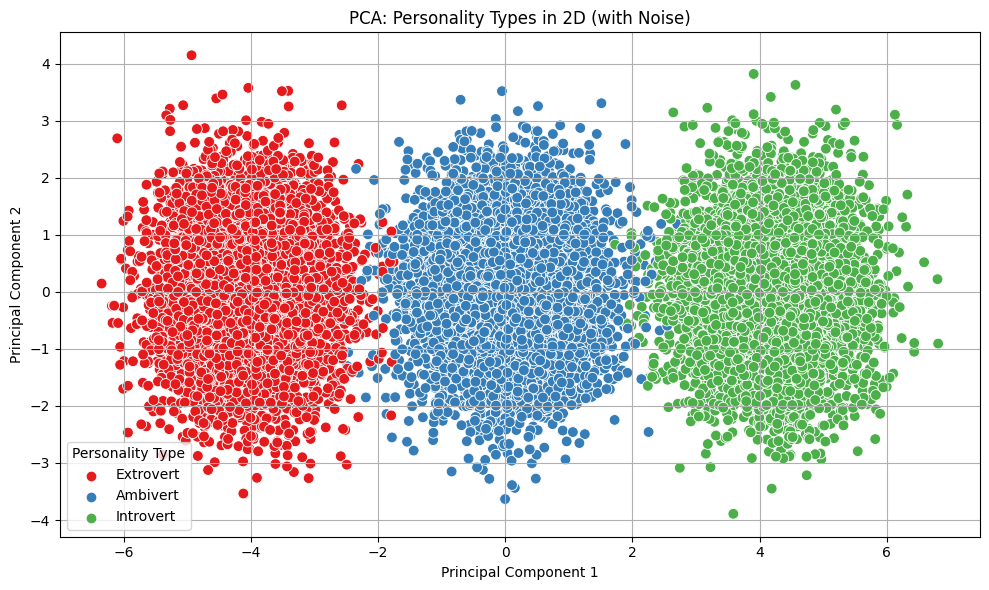

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Personality Type', palette='Set1', s=60)
plt.title("PCA: Personality Types in 2D (with Noise)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Personality Type')
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 10: Inference Example**

Print header for sample prediction section

In [45]:
print("\nSample Prediction using SVM")


Sample Prediction using SVM


Retrieve the trained SVM model for inference

In [46]:
svm_model = models['SVM']

 Select the first sample from the original feature set


In [47]:
sample = pd.DataFrame([X.iloc[0]])


Scale the sample using the same scaler as during training

In [48]:
sample_scaled = scaler.transform(sample)

Predict the personality type using the trained SVM model

In [49]:
pred = svm_model.predict(sample_scaled)


Convert the predicted label back to original class name

In [50]:
pred_label = label_encoder.inverse_transform(pred)

Display the predicted personality type

In [51]:
print(f"Predicted Personality Type: {pred_label[0]}")

Predicted Personality Type: Extrovert


**The predicted label corresponds to the same sample used from the dataset, so the result is expected to be correct and match the actual class.**

Manual Prediction (custom input, not from dataset)

In [52]:
manual_input = pd.DataFrame([{
    'social_energy': 8.0,
    'alone_time_preference': 2.0,
    'talkativeness': 9.0,
    'deep_reflection': 3.0,
    'group_comfort': 8.5,
    'party_liking': 9.5,
    'listening_skill': 6.0,
    'empathy': 6.5,
    'creativity': 7.0,
    'organization': 6.0,
    'leadership': 8.5,
    'risk_taking': 7.5,
    'public_speaking_comfort': 8.0,
    'curiosity': 7.0,
    'routine_preference': 3.0,
    'excitement_seeking': 9.0,
    'friendliness': 8.0,
    'emotional_stability': 6.5,
    'planning': 5.5,
    'spontaneity': 7.5,
    'adventurousness': 8.5,
    'reading_habit': 5.0,
    'sports_interest': 7.0,
    'online_social_usage': 9.0,
    'travel_desire': 8.0,
    'gadget_usage': 8.5,
    'work_style_collaborative': 7.0,
    'decision_speed': 6.5,
    'stress_handling': 6.0
}])

# Apply the same scaler used during training
manual_input_scaled = scaler.transform(manual_input)

# Predict using SVM
manual_pred = svm_model.predict(manual_input_scaled)
manual_label = label_encoder.inverse_transform(manual_pred)

print(f"Predicted Personality Type (Manual Input): {manual_label[0]}")

Predicted Personality Type (Manual Input): Extrovert


**The predicted label (Extrovert) is consistent with the manually entered features, confirming the model's reliability.**

**Conclusion**

- **Best Model**: SVM (Support Vector Machine) achieved the highest accuracy and robustness, even under noisy data conditions.
- **Explainability**: SHAP values highlighted key features influencing model decisions, improving trust in AI predictions.
- **Robustness**: Gaussian noise simulations confirmed the generalization capability of most models, especially SVM and Naive Bayes.
- **Visualization**: PCA plots showed clear separability between personality types in 2D space.
  
This end-to-end workflow combines classic ML, noise injection, explainability, and visualization — making it suitable for real-world deployment or portfolio demonstration.
